# Chatbot with Memory

## Review

Memory is the ability to encode, store, retain, and subsequently recall information and experiences.

We introduced [various long-term memory types](https://langchain-ai.github.io/langgraph/concepts/memory/#memory) and how memories can be updated in AI applications.

## Goals

Here, we'll introduce the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as a way to save and retrieve long-term memories.

We'll build a simple chatbot that uses both `short-term (within-thread)` and `long-term (across-thread)` memory.

It will save long-term [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory) (facts about the user) ["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories), as the user is chatting with it.

In [22]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [8]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Introduction to the LangGraph Store

The [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) provides a way to store and retrieve information for long-term memory *across threads* in LangGraph.

This is an  [open source base class](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/) for persistent `key-value` stores.

In [2]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

When storing objects using the Store interface you define:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

In [23]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, key, value)

We use [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) to retrieve objects from the store by namespace.

In [24]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
memories[0].dict()

{'value': {'food_preference': 'I like pizza'},
 'key': '776c5996-ef8f-4794-b284-4d42d773ad53',
 'namespace': ['1', 'memories'],
 'created_at': '2024-10-26T17:08:13.682192+00:00',
 'updated_at': '2024-10-26T17:08:13.682195+00:00'}

We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by namespace and key.

In [25]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'food_preference': 'I like pizza'},
 'key': '776c5996-ef8f-4794-b284-4d42d773ad53',
 'namespace': ['1', 'memories'],
 'created_at': '2024-10-26T17:08:13.682192+00:00',
 'updated_at': '2024-10-26T17:08:13.682195+00:00'}

## Chatbot that saves memories to the store

Now, let's use the store in a simple chatbot that saves memories. 

In [10]:
_set_env("OPENAI_API_KEY")

We're going to use both short-term (within-thread) and long-term (cross-thread) memory in this chatbot! 

For short-term memory, we'll use the `MemorySaver` checkpointer. 

See Module 2 and our [conceptual docs](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more on checkpointers, but in summary:

* They write the graph state at each step to a thread.
* They allow the graph to be interrupted and resumed from any step in the thread.

For long-term memory, we'll use the [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) as introduced above.

In [11]:
from langchain_openai import ChatOpenAI

# Checkpointer for within-thread memory
from langgraph.checkpoint.memory import MemorySaver

# Initialize the LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

Now, lets define a very simple chatbot where we use a user-provided keyword, `remember`, to save memories to the store.

Here, we're just saving facts about the user that we can retrieve later.

This is an example of [semantic memory](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory)!

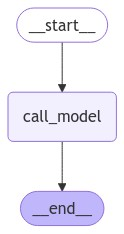

In [14]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_profile = store.get(namespace, "user_profile")

    # Get the last message from the user 
    last_message = state["messages"][-1]

    # Check if it contains the keyword "remember"
    if "remember" in last_message.content.lower():
        
        # Distill chat message as a memory 
        system_msg = f"Create a simple user profile based on the user's message history to save for long-term memory."
        user_msg = f"User messages: {state['messages']}"
        new_profile = model.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content=user_msg)])

        # Save the memory to the store
        key = "user_profile"
        store.put(namespace, key, {"profile": new_profile.content})

    # Format all memories for the system prompt
    system_msg = f"You are a helpful assistant. Here is the profile for the user: {existing_profile.value if existing_profile else None}"
    
    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", END)

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply a user ID for across-thread memory. 

We also supply a thread ID for within-thread memory. 

Let's see how these work together in practice. 

In [15]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# I give the chatbot a message to remember using the keyword "remember"
input_messages = [HumanMessage(content="Hi! Remember: my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?


Because we're using the `MemorySaver` checkpointer for within-thread memory, the chat history is saved to the the thread. 

In [16]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?


Now, I can give the chatbot more things to remember as part of this *same chat thread*. 

In [17]:
# I give the chatbot a message to remember using the keyword "remember"
input_messages = [HumanMessage(content="Hi! Remember: I like to bike")]

# We supply the same user ID for across-thread memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Remember: I like to bike
================================== Ai Message ==================================

Of course, Lance! Biking is a great interest to have. Do you have any biking adventures or plans coming up?


We can see that the checkpointer has persisted our full chat history to the thread.

In [18]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi! Remember: my name is Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?
================================ Human Message =================================

Hi! Remember: I like to bike
================================== Ai Message ==================================

Of course, Lance! Biking is a great interest to have. Do you have any biking adventures or plans coming up?


Now, let's look at something else. 

We compiled the graph with out store for across-thread memory, `in_memory_store`. 

We *should* have save some memories to it because we passed the keyword `remember` with some of our messages! 

We can check easily.

In [19]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)

# Search 
for memory in in_memory_store.search(namespace):
    print(memory.value)

{'profile': "User Profile:\n\n- Name: Lance\n- Interests: Biking\n\nThis profile is based on the user's message history and will be used for long-term memory to personalize future interactions."}


Good, so the Store has saved specified memories that are accessible across threads.

And the checkpointer has saved the chat history of the current thread. 

This allows us to resume from where we left off several times in the above conversation.

Now, let's kick off a *new thread* with the *same user ID*.

Let's see if we can retrieve the memories from the previous thread.

In [20]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# I give the chatbot a message to remember using the keyword "remember"
input_messages = [HumanMessage(content="Hi!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello, Lance! How's it going? Have you been on any interesting bike rides lately?


We can see that the chatbot has retrieved the memories from the previous thread.

It knows my name and that I like to bike.

We can also confirm that the prior chat history is *not* persisted to the new thread.

In [21]:
thread = {"configurable": {"thread_id": "2"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello, Lance! How's it going? Have you been on any interesting bike rides lately?


## Viewing traces in LangSmith

We can check that memories were loaded from the store by looking at the LangSmith trace. 

We can see that the memories are retrieved from the store and supplied as part of the system prompt, as expected:

https://smith.langchain.com/public/5c219343-4db8-43b1-93c2-670bd9434132/r

## Studio

We can also interact with our chatbot in Studio. 

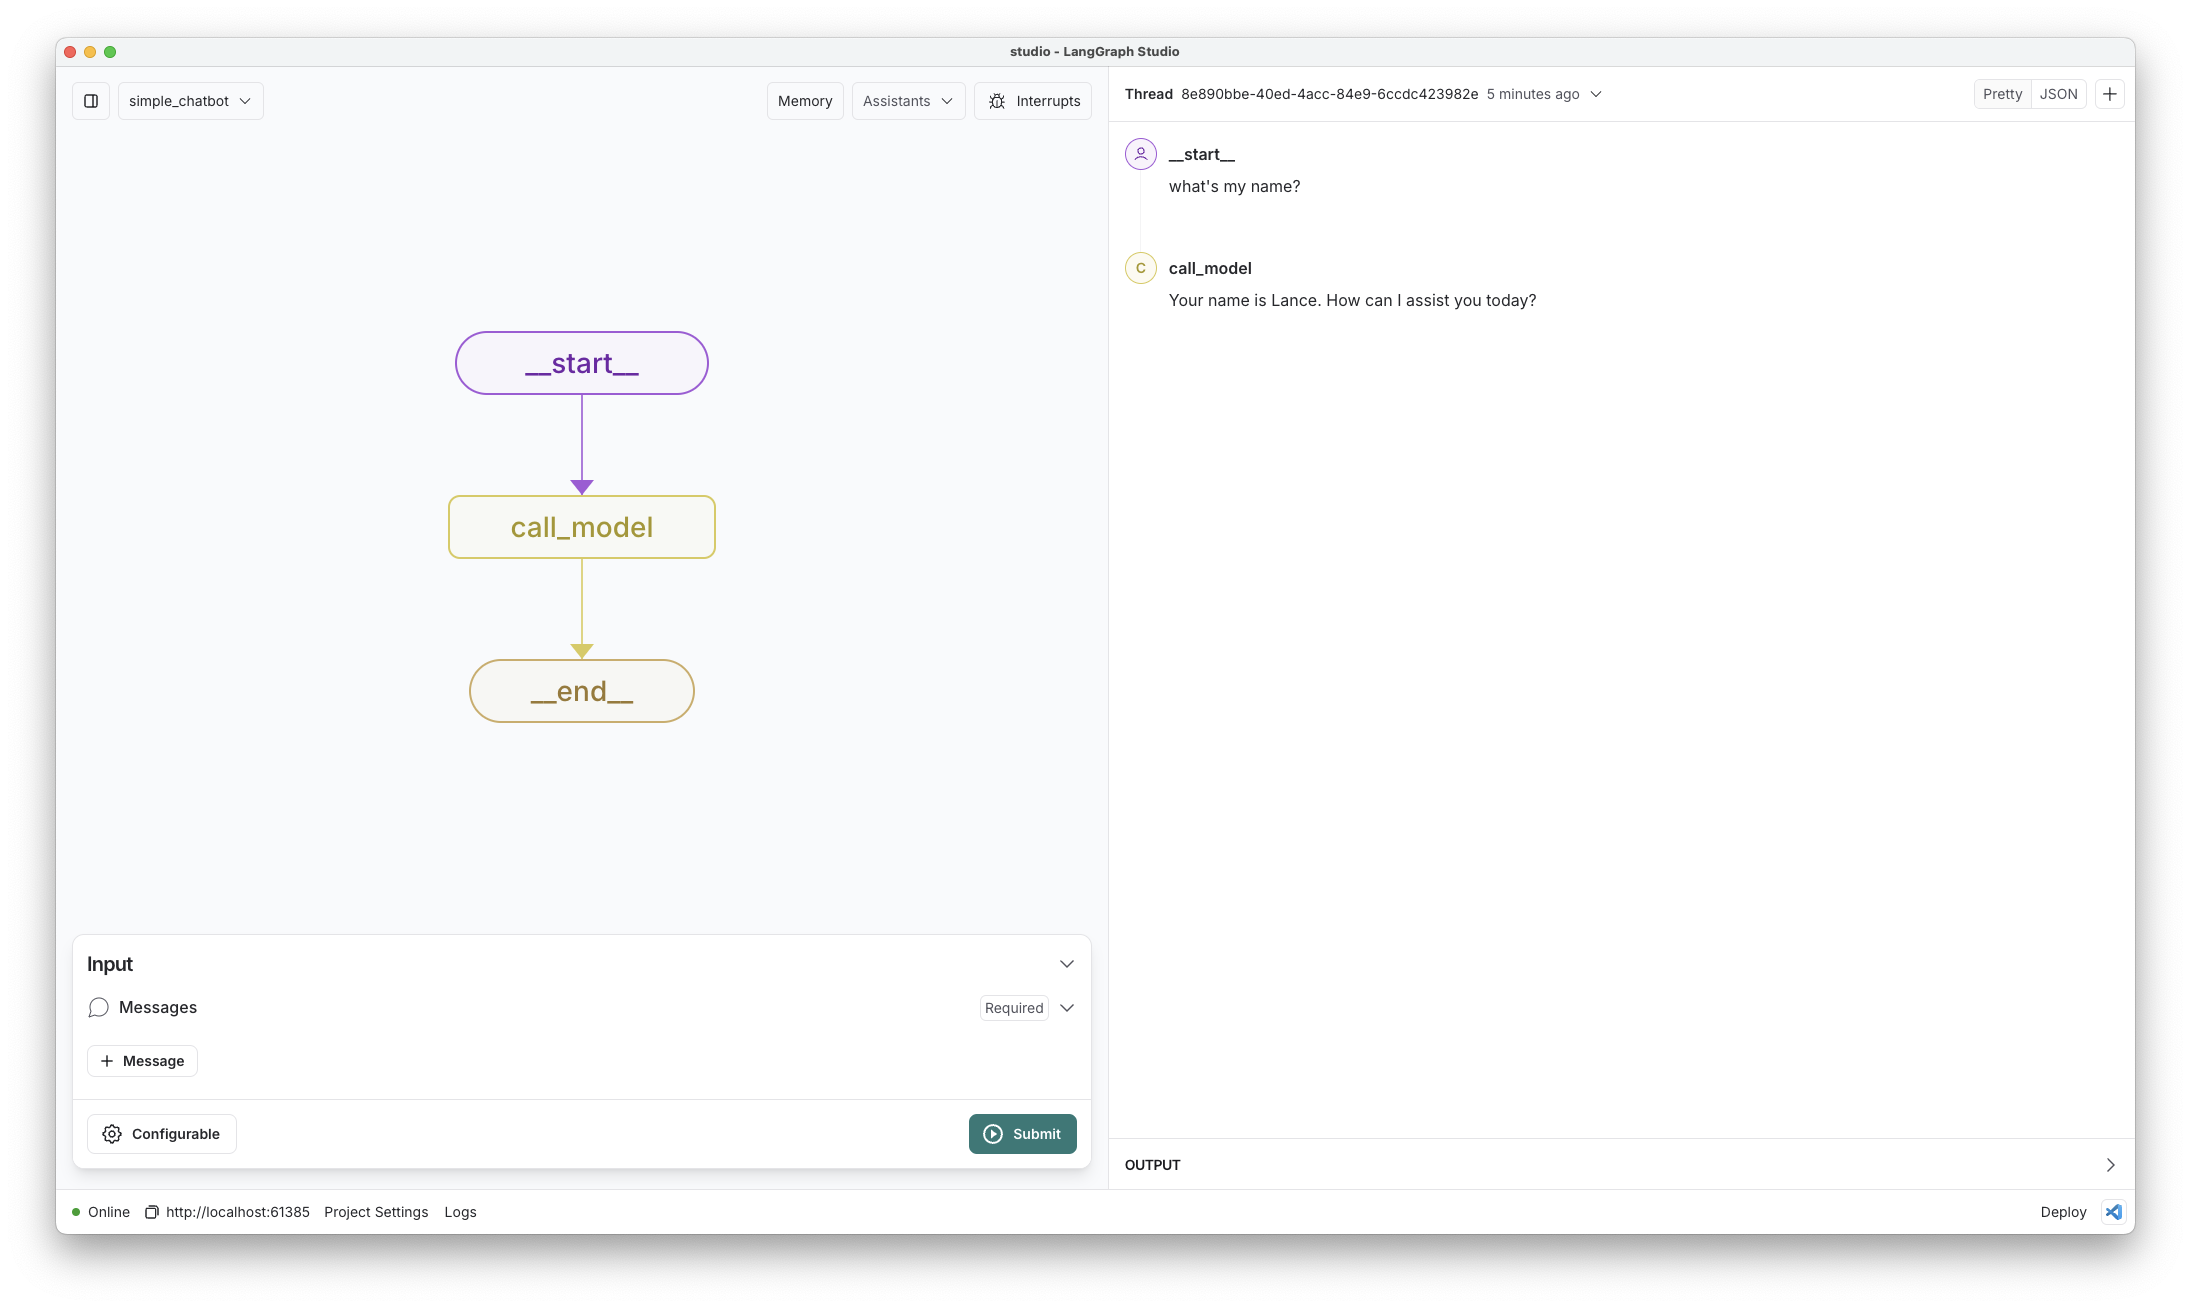

We'll add a [runtime configuration](https://langchain-ai.github.io/langgraph/how-tos/configuration/) to our graph to allow us to set the user ID from the Studio UI.

The `Store` is built-into the LangGraph API, so it's accessible to us in Studio scoped to each project. 

By default, the `Store` in the LangGraph API is backed by Postgres.

Studio has a `Memories` tab that allows us to see memories that are saved to the `Store`.

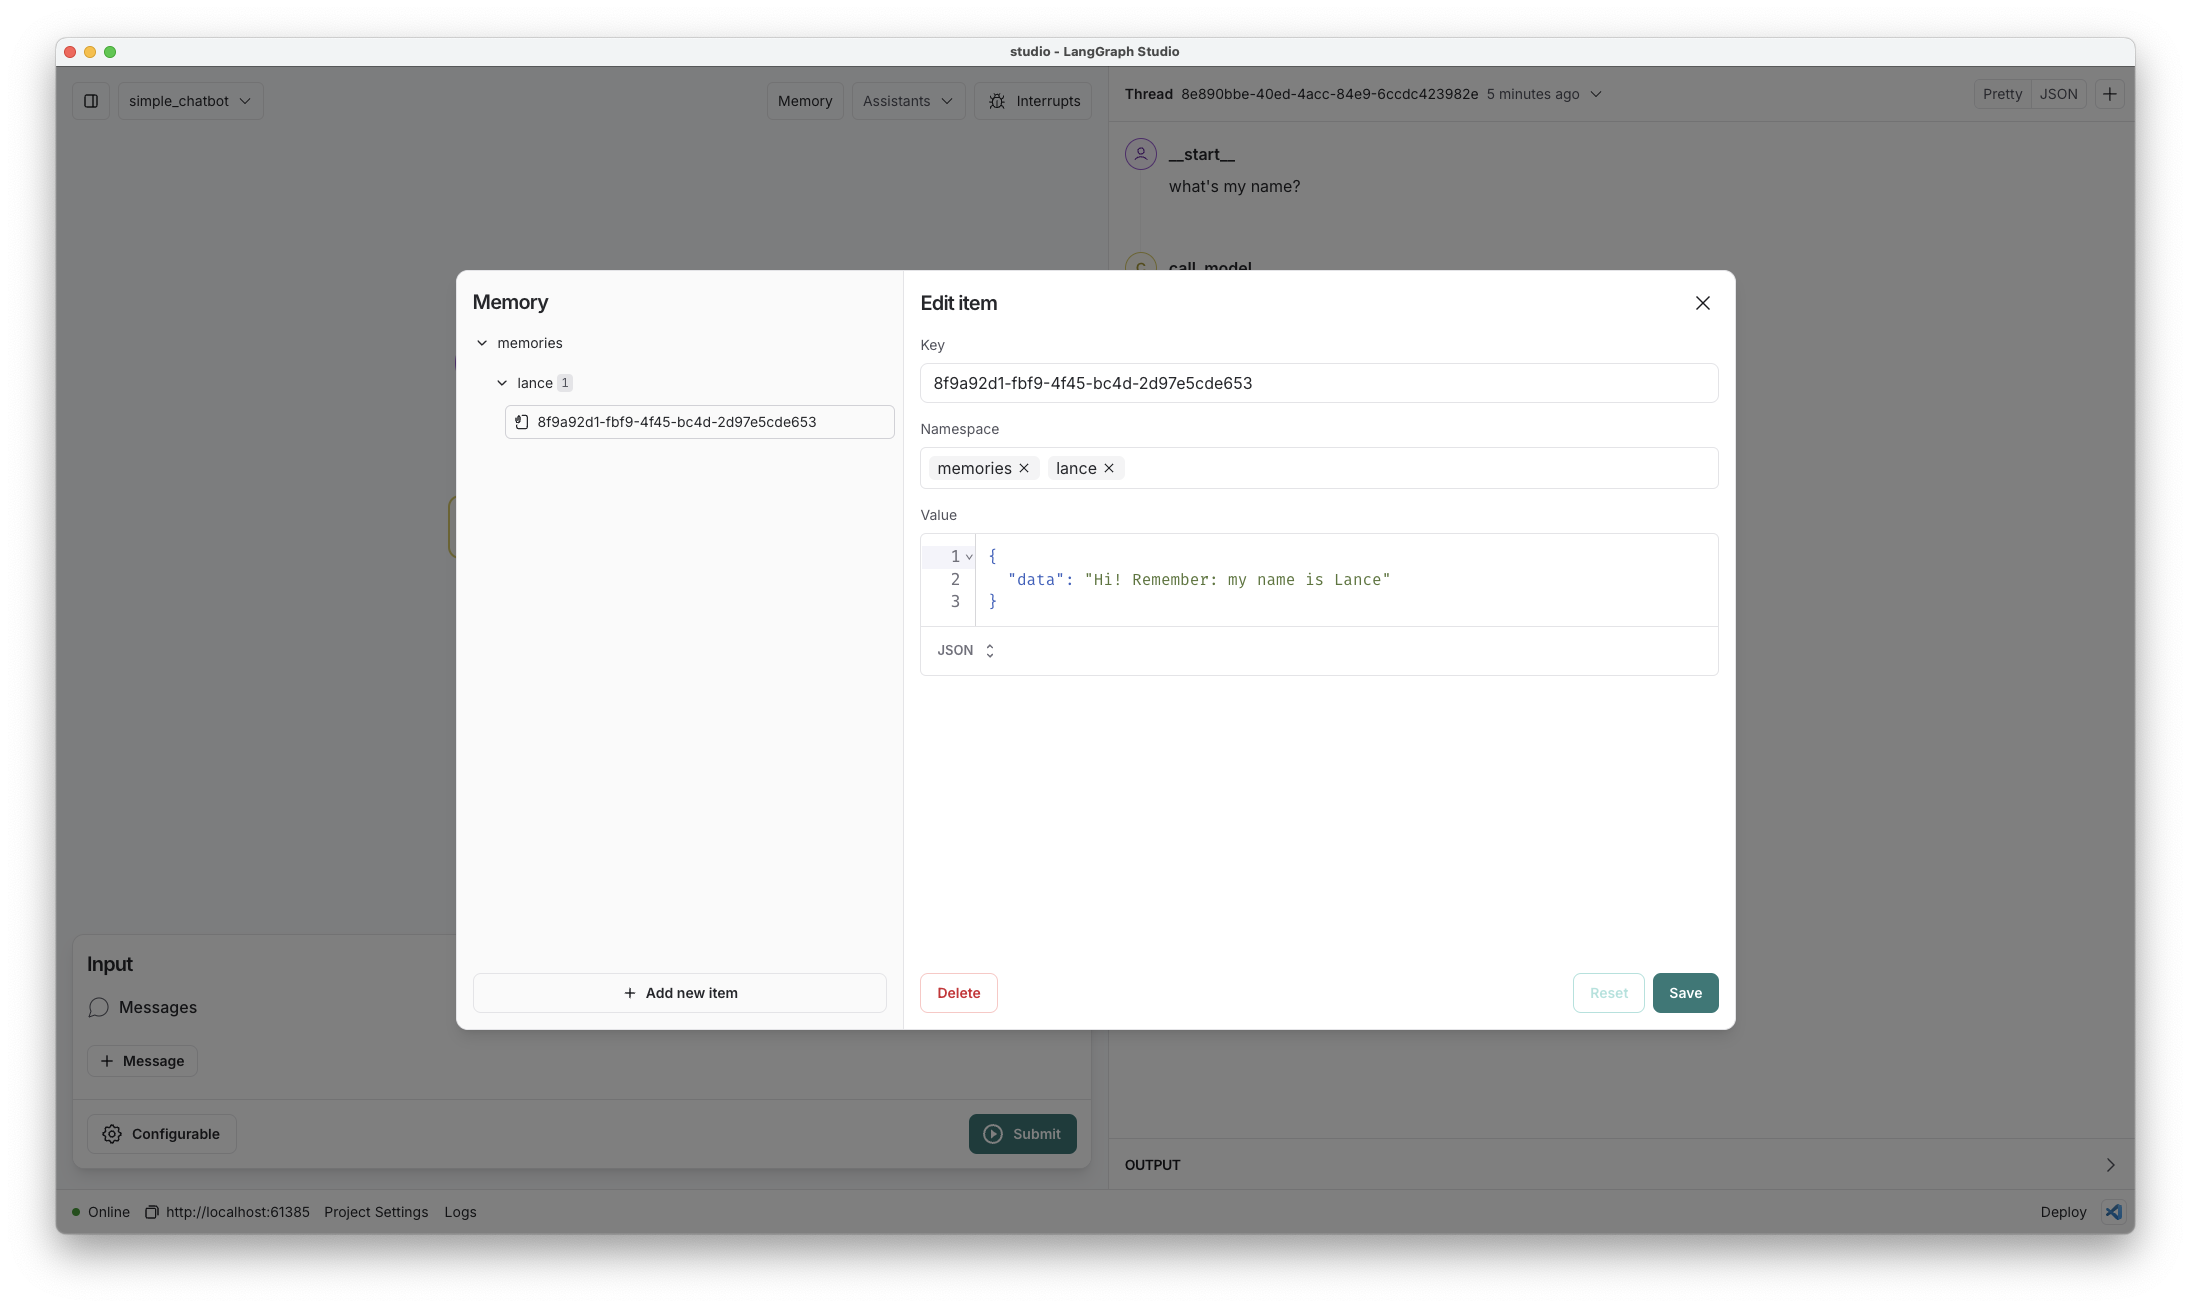